# Домашнее задание №2

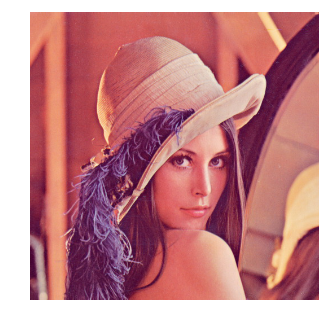

In [1]:
import cv2
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

def show(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

img = cv2.imread("lena.jpg")
show(img)

**1. (3 балла)** Реализуйте самостоятельно функцию градационного преобразования вида $T(r)=ar+b$, просто с помощью попиксельного обхода изображения. Примените его к изображению lena.jpg с параметрами $a = 2$, $b = 100$. Примените к исходному изображению стандартную функцию $convertTo$ с теми же параметрами. Убедитесь, что получилось одно и то же.                                                            

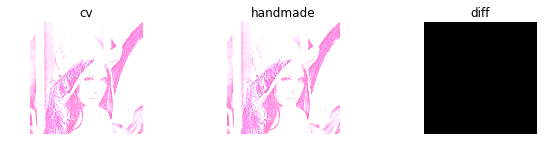

In [2]:
def T(r, a, b):
    def overflow_handler(x):
        return 255 if x > 255 else x
    return np.vectorize(lambda x: overflow_handler(np.abs(a * x + b)), otypes=[np.uint8])(r)

my_transform = T(img, 2, 100)
cv_transform = cv2.convertScaleAbs(img, alpha=2, beta=100)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10,2))
for ax in [ax1, ax2, ax3]:
    ax.set_axis_off()
ax1.imshow(cv2.cvtColor(cv_transform, cv2.COLOR_BGR2RGB))
ax1.set_title('cv')
ax2.imshow(cv2.cvtColor(my_transform, cv2.COLOR_BGR2RGB))
ax2.set_title('handmade')
ax3.imshow(cv2.cvtColor(cv2.absdiff(cv_transform, my_transform), cv2.COLOR_BGR2RGB))
ax3.set_title('diff')
plt.show()

**2. (3 балла)** Загрузите изображение lena.jpg. Усредните значения всех трех цветовых каналов в каждый из каналов итогового изображения.

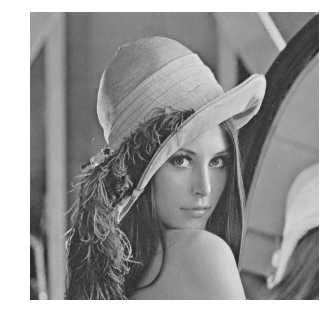

In [3]:
lena = cv2.imread("lena.jpg")
b, g, r = cv2.split(lena)
r, g, b = [c.astype(np.int16) for c in [r, g, b]]
gray = ((r + g + b) // 3).astype(np.uint8)
show(cv2.merge((gray, gray, gray)))

**3. (3 балла)** Загрузите изображение $lena.jpg$. Переведите изображение в градации серого. Примените к серому изображению операцию линейного растяжения диапазона яркостей ($normalize$) и эквализации гистограммы ($equalizeHist$). Постройте разность полученных результатов. Состыкуйте в одно изображение в градациях серого результат линейного растяжения, эквализации и их разности.

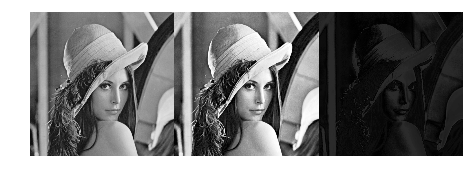

In [4]:
from matplotlib import pyplot as plt
lena = cv2.imread("lena.jpg")
gray_lena = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)
norm_lena = cv2.normalize(gray_lena, None, 0, 255, cv2.NORM_MINMAX)
equalized_lena = cv2.equalizeHist(gray_lena, None)
diff = cv2.absdiff(norm_lena, equalized_lena)
ax = plt.axes([0,0,1,1], frameon=False)
ax.set_axis_off()
plt.imshow(np.hstack((norm_lena, equalized_lena, diff)), cmap='gray')
plt.show()

**4. (3 балла) ** Реализуйте функцию добавления шума «соль и перец» для одноканального изображения. Входные параметры: $src$ – исходная одноканальная матрица $Mat$, $p$ – вероятность замещения исходных значений на $0$, $q$ – вероятность замещения исходных значений на $255$. Загрузите изображение $lena.jpg$, выделите каналы изображения в отдельные матрицы ($split$), добавьте шум «соль и перец» в каждый канал при помощи реализованной Вами функции с параметрами

1. $p=q=0.05$
2. $p=q=0.1$
3. $p=q=0.15$

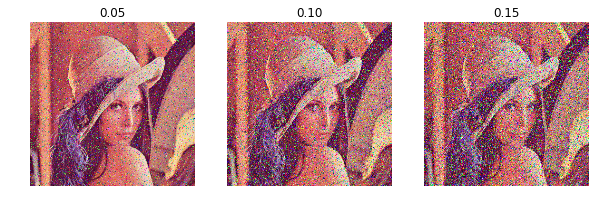

In [5]:
def check_prob(p):
    return np.random.uniform() < p

def salt_pepper_pixel(x, p, q):

    if check_prob(p):
        return 0
    if check_prob(q):
        return 255
    return x

def salt_pepper(src, p, q):
    return np.vectorize(lambda x: salt_pepper_pixel(x, p, q), otypes=[np.uint8])(src)

b, g, r = cv2.split(cv2.imread("lena.jpg"))
pqs = [(0.05, 0.05), (0.1, 0.1), (0.15, 0.15)]
images = []

for p, q in pqs:
    nb, ng, nr = [salt_pepper(c, p, q) for c in [b, g, r]]
    images.append(cv2.merge((nr, ng, nb)))
    

titles = ['0.05', '0.10', '0.15']
fig, axs = plt.subplots(ncols=3, figsize=(10,3))
for i in range(len(images)):
    axs[i].axis('off')
    axs[i].imshow(images[i])
    axs[i].set_title(titles[i])

plt.show()

**5. (6 баллов)** Загрузите изображение $lena.jpg$ (512х512). Переведите изображение в градации серого. Произведите фильтрацию данного изображения в частотной области идеальным фильтром низких частот (фильтр, обрезающий все высокочастотные составляющие Фурье-образа, находящиеся на большем расстоянии от начала координат, чем некоторое заданное расстояние $D$), идеальным фильтром высоких частот (фильтр, обрезающий все низкокочастотные составляющие Фурье-образа, находящиеся на меньшем расстоянии от начала координат, чем некоторое заданное расстояние $D$) со следующими значениями радиуса фильтров:
1. 5
2. 15
3. 30
4. 255

Для каждого фильтра постройте состыкованное изображение из следующих: исходное изображение в градациях серого, изображение Фурье-спектра (после логарифмической коррекции для лучшей визуализации), изображение Фурье-спектра после фильтрации, изображение в пространственной области после фильтрации. На выходе должно получиться 8 изображений (4 параметра фильтров х 2 типа фильтров). Функции, которые Вам потребуются: $dft$, $mulSpectrums$, $idft$.

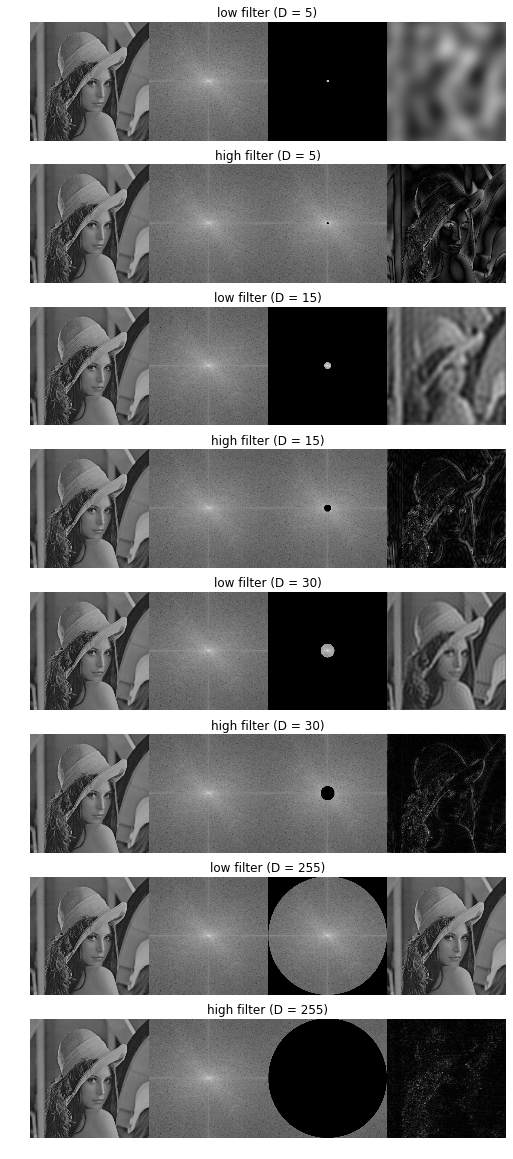

In [6]:
from matplotlib import pyplot as plt
gray_lena = cv2.imread("lena.jpg", 0)

def image_from_sdft(sdft):
    back = cv2.idft(np.fft.ifftshift(sdft))
    x = cv2.magnitude(back[:,:,0], back[:,:,1])
    return 255 * x / x.max()

def show_gray(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(img, cmap='gray')

dft = cv2.dft(np.float32(gray_lena), flags = cv2.DFT_COMPLEX_OUTPUT)
shifted_dft = np.fft.fftshift(dft)

distances = [5, 15, 30, 255]
images = []

def custom_filter(sdft, f):
    w, h, _ = sdft.shape
    filtered_dft = np.copy(sdft)
    for x in range(w):
        for y in range(h):
            if f(x, y):
                filtered_dft[x][y] = [0, 0]
    return filtered_dft

def low_filter(sdft, D):
    w, h, _ = sdft.shape
    return custom_filter(sdft, lambda x,y : (x-w/2)**2+(y-h/2)**2 > D**2)

def high_filter(sdft, D):
    w, h, _ = sdft.shape
    return custom_filter(sdft, lambda x,y : (x-w/2)**2+(y-h/2)**2 < D**2)

def get_spectrum(sdft):
    return 20 * np.log(np.abs(cv2.magnitude(sdft[:,:,0], sdft[:,:,1]))+1)

def combine_images(original_sdft, filtered_sdft):
    original = image_from_sdft(original_sdft)
    original_spectrum = get_spectrum(original_sdft)
    filtered = image_from_sdft(filtered_sdft)
    filtered_spectrum = get_spectrum(filtered_sdft)
    return np.hstack((original, original_spectrum, filtered_spectrum, filtered))

n = len(distances)
fig, axs = plt.subplots(nrows=(2 * n), figsize=(10,20))
for i in range(n):
    ax = axs[2 * i]
    ax.set_axis_off()
    ax.set_title('low filter (D = {})'.format(distances[i]))
    ax.imshow(combine_images(shifted_dft, low_filter(shifted_dft, distances[i])), cmap='gray')
    ax = axs[2 * i + 1]
    ax.set_axis_off()
    ax.set_title('high filter (D = {})'.format(distances[i]))
    ax.imshow(combine_images(shifted_dft, high_filter(shifted_dft, distances[i])), cmap='gray')

plt.show()


**6. (5 баллов) **Удалите диагональные полоски с изображения $lena\_diagonal.jpg$. Вычислите среднеквадратичную ошибку (mean squared error, $MSE$, \url{http://en.wikipedia.org/wiki/Mean_squared_error}) для полученного результата и изображения $lena\_gray\_512.tif$. Задача будет засчитана при $MSE < 1500$. Тот, у кого по результатам проверки будет наименьшее значение MSE среди всех студентов для этой задачи, получит призовую шоколадку (раньше мы раздавали призовые баллы, но теперь у нас концепция фиксированного максимального количества баллов)

99.8434715271


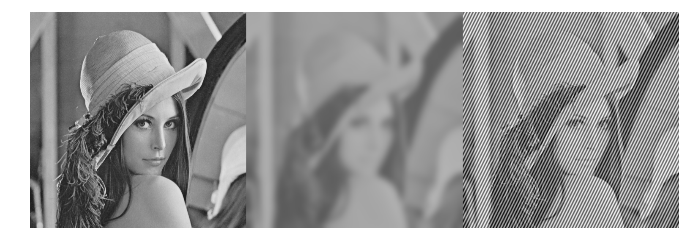

In [7]:
img1 = cv2.imread("lena_diagonal.jpg")
ideal = cv2.imread("lena_gray_512.tif")

def calc_MSE(a, b):
    return ((a - b) ** 2).mean()

best_mse = calc_MSE(img1, ideal)
best_k = -1

for x in range(1, 52, 2):
    filtered = cv2.GaussianBlur(img1, (x, x), 0)
    t = calc_MSE(filtered, ideal)
    if best_mse > t:
        best_mse, best_k = t, x

plt.figure(figsize=(10, 3))
show(np.hstack((ideal, cv2.GaussianBlur(img1, (x, x), 0), img1)))
print(best_mse)


**7. (5 баллов)** Подавите шум на изображении $lena\_color\_512\_noise.tif$. Вычислите среднеквадратичную ошибку ($MSE$) для полученного результата и изображения $lena\_color\_512.tif$. Задача будет засчитана при $MSE < 150$. Тот, у кого по результатам проверки будет наименьшее значение $MSE$ среди всех студентов для этой задачи, получит призовую шоколадку.

55.9105923971


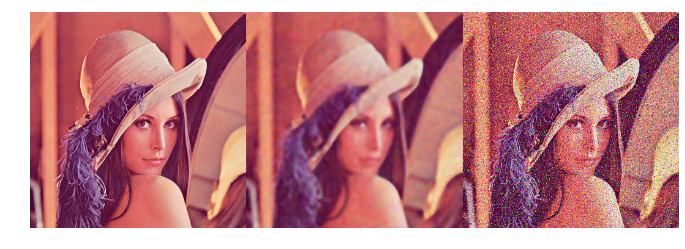

In [8]:
img1 = cv2.imread("lena_color_512-noise.tif")
ideal = cv2.imread("lena_color_512.tif")

def calc_MSE(a, b):
    return ((a - b) ** 2).mean()

best_mse = calc_MSE(img1, ideal)
best_k = -1

for x in range(1, 52, 2):
    filtered = cv2.medianBlur(img1, ksize=x)
    t = calc_MSE(filtered, ideal)
    if best_mse > t:
        best_mse, best_k = t, x

plt.figure(figsize=(10, 3))
show(np.hstack((ideal, cv2.medianBlur(img1, ksize=best_k), img1)))
print(best_mse)


**8. (5 баллов)** Реализуйте функцию пространственной фильтрации изображения однородным усредняющим фильтром размера $n \times n$ (все коэффициенты маски равны $\frac{1}{n^2}$). При вычислении среднего используйте тот факт, что при переходе от точки к точке обновляется только часть элементов изображения под маской. Примените реализованный фильтр к предварительно переведенному в градации серого изображению $lena.jpg$ при $n = 3$ и $n = 5$. Постройте и сохраните изображение, представляющее собой разность полученных результатов фильтрации.

In [9]:
def average_filter_color(img, n):
    b, g, r = cv2.split(img)
    b = average_filter_gray(b, n)
    g = average_filter_gray(g, n)
    r = average_filter_gray(r, n)    
    return cv2.merge((b, g, r))

def average_filter_gray(img, n):
    w, h = img.shape
    n2 = n // 2
    p = np.zeros((w + n, h + n))
    p[n2:w+n2, n2:h+n2] = img
    result = np.zeros((w , h))
    s = 0
    for x in range(w):
        for y in range(h):
            if y == 0:
                s = p[x:x+n,y:y+n].sum()
            else:
                s += p[x:x+n,y+n-1].sum() - p[x:x+n,y-1].sum()
            result[x][y] = s
    return result / n**2

lena = cv2.imread("lena.jpg")
lena3 = average_filter_color(lena, 3)
lena5 = average_filter_color(lena, 5)
diff = cv2.absdiff(lena3, lena5)
cv2.imwrite("task8.jpg", diff)

img = np.vstack((lena3, lena5, diff))

            